# Tradução Automática e o Conjunto de Dados (eng→fra)
Este notebook implementa a seção **9.5** do *Dive into Deep Learning* (D2L) para o par **inglês→francês**, incluindo:

- Download e **pré-processamento** (inglês\tfrancês)
- **Tokenização** (nível de palavra) e **vocabulários** separados (src/tgt)
- **Histograma** de comprimentos (tokens por sequência)
- **Truncamento** / **padding** e carregamento em **minibatches**
- **Experimentos 9.5.7** (efeito de `num_examples` nos vocabulários)


In [1]:
# (Opcional) instalar Hugging Face datasets — só se precisar dos fallbacks
try:
    import datasets  # noqa
except Exception:
    !pip -q install datasets==2.21.0

import os, sys, io, csv, zipfile, urllib.request, random, math, typing as T
import numpy as np
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
try:
    import datasets
    print("datasets:", datasets.__version__)
except Exception as e:
    print("datasets: não instalado (só necessário nos fallbacks HF)")


Python: 3.12.11
datasets: 4.0.0


## 1) Configuração
Ajuste `NUM_EXAMPLES` (para os experimentos) e `NUM_STEPS` (tamanho fixo por sequência após truncamento/padding).


In [2]:
# Par de idiomas (fixo em eng→fra nesta seção)
SRC_LANG = 'eng'
TGT_LANG = 'fra'

# Limites de dados
NUM_EXAMPLES = 60000       # usado no fluxo principal (corte após obter os dados)
MAX_LEN = 50               # descartar sequências muito longas antes de construir vocabulário

# Batching para a etapa 9.5 (não é treinamento de modelo; só minibatches p/ visualização)
BATCH_SIZE = 2
NUM_STEPS = 8              # comprimento fixo por sequência após truncamento/padding (para fins didáticos)

# Experimentos 9.5.7: varredura de exemplos
NUM_EXAMPLES_SWEEP = [500, 1000, 2000, 6000, 10000, 20000]

# Vocabulário
MIN_FREQ = 2
RESERVED_TOKENS = ['<pad>', '<bos>', '<eos>']

# Semente
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## 2) Obtenção do conjunto de dados (eng–fra) com fallbacks

Ordem de tentativas:
1. **D2L S3** (`fra-eng.zip` → `fra.txt`)
2. **TensorFlow GCS** (`fra-eng.zip` → `fra.txt`)
3. **Hugging Face — Tatoeba Challenge** (`Helsinki-NLP/tatoeba_mt`, config `eng-fra`)
4. **Hugging Face — OPUS Books** (`opus_books`, config `en-fr`)
5. **Upload manual** de um `.tsv/.txt` no formato `ENGLISH<TAB>FRENCH`

No final, produzimos `raw_text` com linhas `english\tfrench`.


In [4]:
def _fetch(url: str, out_path: str, headers: dict | None = None) -> bool:
    try:
        print("Baixando:", url)
        if headers:
            req = urllib.request.Request(url, headers=headers)
            with urllib.request.urlopen(req, timeout=60) as r, open(out_path, "wb") as f:
                f.write(r.read())
        else:
            urllib.request.urlretrieve(url, out_path)
        return True
    except Exception as e:
        print("Falhou:", e)
        return False

def _extract_first_txt(zip_path: str, dest: str = "/content") -> str | None:
    try:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(dest)
            txts = [n for n in zf.namelist() if n.endswith(".txt")]
            if txts:
                return os.path.join(dest, txts[0])
    except Exception as e:
        print("Falha ao extrair:", e)
    return None

def _load_raw_from_txt(path: str, max_items: int | None = None) -> str:
    """Lê arquivo com linhas 'eng\\tfra' e devolve uma string grande com o mesmo formato."""
    buf = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if max_items and i >= max_items: break
            parts = line.rstrip("\n")
            if parts.count("\t") >= 1:
                # mantém apenas as 2 primeiras colunas
                a, b = parts.split("\t")[:2]
                buf.append(f"{a}\t{b}")
    return "\n".join(buf)

def _load_raw_tatoeba_hf(max_items: int | None = None) -> tuple[str | None, int]:
    """Hugging Face: Helsinki-NLP/tatoeba_mt (split 'test' costuma ter pares)."""
    try:
        from datasets import load_dataset
        ds = load_dataset("Helsinki-NLP/tatoeba_mt", "eng-fra", split="test")
        rows = []
        for i, ex in enumerate(ds):
            # formato comum: source_sentence / target_sentence
            if "source_sentence" in ex and "target_sentence" in ex:
                rows.append(f"{ex['source_sentence']}\t{ex['target_sentence']}")
            elif "translation" in ex and isinstance(ex["translation"], dict):
                tr = ex["translation"]
                if "en" in tr and "fr" in tr:
                    rows.append(f"{tr['en']}\t{tr['fr']}")
            if max_items and len(rows) >= max_items:
                break
        return ("\n".join(rows), len(rows)) if rows else (None, 0)
    except Exception as e:
        print("[HF:tatoeba_mt] Falhou:", e)
        return (None, 0)

def _load_raw_opus_books(max_items: int | None = None) -> tuple[str | None, int]:
    """Hugging Face: opus_books en-fr."""
    try:
        from datasets import load_dataset
        ds = load_dataset("opus_books", "en-fr", split="train")
        rows = []
        for i, ex in enumerate(ds):
            tr = ex.get("translation", {})
            if "en" in tr and "fr" in tr:
                rows.append(f"{tr['en']}\t{tr['fr']}")
            if max_items and len(rows) >= max_items:
                break
        return ("\n".join(rows), len(rows)) if rows else (None, 0)
    except Exception as e:
        print("[HF:opus_books] Falhou:", e)
        return (None, 0)

def get_raw_text_eng_fra(max_items: int | None = None) -> tuple[str, str]:
    """Orquestra as fontes e retorna (raw_text, fonte)."""
    # 1) D2L S3
    d2l_url = "http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip"
    out = "/content/fra-eng_d2l.zip"
    if _fetch(d2l_url, out):
        txt = _extract_first_txt(out, "/content")
        if txt and os.path.exists(txt):
            print("Fonte: D2L S3")
            return _load_raw_from_txt(txt, max_items), "D2L S3"

    # 2) TensorFlow GCS
    tf_url = "https://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip"
    out = "/content/fra-eng_tf.zip"
    if _fetch(tf_url, out):
        txt = _extract_first_txt(out, "/content")
        # normalmente o nome é 'fra.txt'
        if not txt and os.path.exists("/content/fra.txt"):
            txt = "/content/fra.txt"
        if txt and os.path.exists(txt):
            print("Fonte: TensorFlow GCS")
            return _load_raw_from_txt(txt, max_items), "TF GCS"

    # 3) Hugging Face — Tatoeba
    raw, n = _load_raw_tatoeba_hf(max_items=max_items)
    if raw:
        print("Fonte: HF Tatoeba (Helsinki)")
        return raw, "HF Tatoeba"

    # 4) Hugging Face — OPUS Books
    raw, n = _load_raw_opus_books(max_items=max_items)
    if raw:
        print("Fonte: HF OPUS Books")
        return raw, "HF OPUS Books"

    # 5) Upload manual (Colab)
    try:
        from google.colab import files
        print("⚠️ Faça upload de um .tsv/.txt com 'ENGLISH<TAB>FRENCH'...")
        up = files.upload()
        for name, content in up.items():
            text = content.decode("utf-8", errors="ignore")
            # valida se há TABs
            if "\t" in text:
                print("Fonte: Upload manual")
                # Se max_items, corta
                lines = text.splitlines()
                if max_items: lines = lines[:max_items]
                return "\n".join(lines), "Upload manual"
    except Exception as e:
        print("Upload manual indisponível (fora do Colab?):", e)

    raise RuntimeError("Não foi possível obter dados de eng–fra (D2L/TF/HF/upload).")

# Executar a aquisição
raw_text, DATA_SOURCE = get_raw_text_eng_fra(max_items=NUM_EXAMPLES)
print("Primeiras linhas:\n", "\n".join(raw_text.splitlines()[:5]))
print("Fonte de dados:", DATA_SOURCE)


Baixando: http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip
Fonte: D2L S3
Primeiras linhas:
 Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Fonte de dados: D2L S3


## 3) Pré-processamento
- Substitui NBSP por espaço; **lowercase**
- Insere espaço antes de pontuações (`.,!?`) quando necessário


In [5]:
def preprocess_nmt(text: str) -> str:
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # NBSP → espaço, minúsculas
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # inserir espaço apropriado antes de pontuação
    out = [' ' + c if i > 0 and no_space(c, text[i-1]) else c
           for i, c in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print("\n".join(text.splitlines()[:5]))


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?


## 4) Tokenização (nível de palavra)
Converte cada linha `eng\tfra` em duas listas de tokens.


In [6]:
def tokenize_nmt(text: str, num_examples: int | None = None):
    src, tgt = [], []
    for i, line in enumerate(text.split("\n")):
        if not line.strip():
            continue
        if num_examples is not None and i >= num_examples:
            break
        parts = line.split("\t")
        if len(parts) < 2:
            continue
        src.append(parts[0].split(" "))
        tgt.append(parts[1].split(" "))
    return src, tgt

source, target = tokenize_nmt(text, num_examples=None)
print("Exemplos tokenizados (6):")
print(source[:6], target[:6])


Exemplos tokenizados (6):
[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!']] [['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?'], ['ça', 'alors', '!']]


## 5) Histograma — nº de tokens por sequência
A maior parte das sequências costuma ter menos de ~20 tokens.


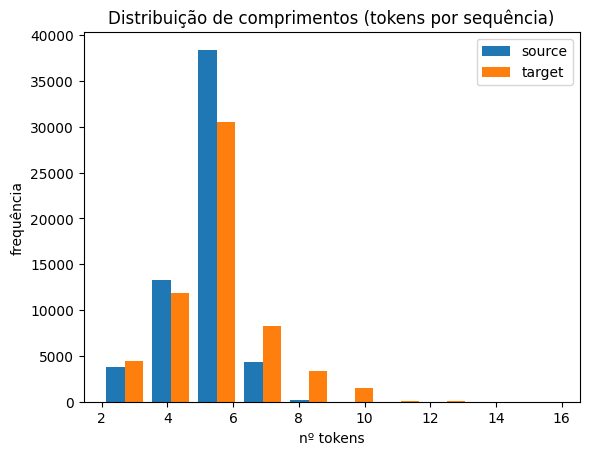

In [7]:
plt.figure()
_ = plt.hist([[len(x) for x in source], [len(y) for y in target]], label=["source", "target"])
plt.legend(loc="upper right")
plt.title("Distribuição de comprimentos (tokens por sequência)")
plt.xlabel("nº tokens")
plt.ylabel("frequência")
plt.show()


## 6) Vocabulários (src/tgt)
- **`min_freq=2`** → tokens raros viram `<unk>`  
- **Reservados**: `<pad>`, `<bos>`, `<eos>`


In [8]:
from collections import Counter, defaultdict

class Vocab:
    def __init__(self, tokens: list[list[str]], min_freq=1, reserved_tokens=None):
        reserved_tokens = reserved_tokens or []
        # contagem
        counter = Counter()
        for seq in tokens:
            counter.update(seq)
        # ordem: reservados primeiro
        self.itos = list(reserved_tokens)
        self.stoi = {}
        # adiciona por frequência
        for tok, freq in counter.most_common():
            if freq >= min_freq and tok not in self.itos:
                self.itos.append(tok)
        # mapeamentos
        for i, tok in enumerate(self.itos):
            self.stoi[tok] = i
        # <unk>
        if "<unk>" not in self.stoi:
            self.itos.append("<unk>")
            self.stoi["<unk>"] = len(self.itos) - 1

    def __len__(self):
        return len(self.itos)

    def to_indices(self, tokens: list[str]) -> list[int]:
        return [self.stoi.get(t, self.stoi["<unk>"]) for t in tokens]

# construir src/tgt vocabulários
src_vocab = Vocab(source, min_freq=MIN_FREQ, reserved_tokens=RESERVED_TOKENS)
tgt_vocab = Vocab(target, min_freq=MIN_FREQ, reserved_tokens=RESERVED_TOKENS)
print("Tamanho vocab SRC:", len(src_vocab))
print("Tamanho vocab TGT:", len(tgt_vocab))


Tamanho vocab SRC: 4764
Tamanho vocab TGT: 8224


## 7) Truncamento / Padding e Minibatches
- `truncate_pad`: corta ou preenche até `NUM_STEPS`
- `build_array_nmt`: converte listas de tokens em índices + `<eos>`, aplica `truncate_pad`, computa `valid_len`
- `load_data_nmt`: junta tudo e cria um *data loader* simples


In [9]:
def truncate_pad(line_ids: list[int], num_steps: int, pad_id: int) -> list[int]:
    if len(line_ids) > num_steps:
        return line_ids[:num_steps]
    return line_ids + [pad_id] * (num_steps - len(line_ids))

def build_array_nmt(lines: list[list[str]], vocab: Vocab, num_steps: int):
    # adiciona <eos>
    eos_id = vocab.stoi["<eos>"]
    pad_id = vocab.stoi["<pad>"]
    arr = []
    valid_len = []
    for toks in lines:
        ids = vocab.to_indices(toks) + [eos_id]
        ids = truncate_pad(ids, num_steps, pad_id)
        arr.append(ids)
        valid_len.append(sum(1 for x in ids if x != pad_id))
    return np.array(arr, dtype=np.int32), np.array(valid_len, dtype=np.int32)

def load_data_nmt(batch_size: int, num_steps: int, num_examples: int = 600):
    # limitar o conjunto de trabalho
    n = min(num_examples, len(source), len(target))
    src = source[:n]
    tgt = target[:n]

    # vocabulários específicos do subconjunto
    src_v = Vocab(src, min_freq=MIN_FREQ, reserved_tokens=RESERVED_TOKENS)
    tgt_v = Vocab(tgt, min_freq=MIN_FREQ, reserved_tokens=RESERVED_TOKENS)

    src_array, src_valid_len = build_array_nmt(src, src_v, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(tgt, tgt_v, num_steps)

    # simples gerador em lotes (embaralha por época)
    idx = np.arange(n)
    def data_iter():
        while True:
            np.random.shuffle(idx)
            for i in range(0, n, batch_size):
                batch_idx = idx[i:i+batch_size]
                yield (src_array[batch_idx], src_valid_len[batch_idx],
                       tgt_array[batch_idx], tgt_valid_len[batch_idx])
    return data_iter(), src_v, tgt_v

train_iter, src_v_small, tgt_v_small = load_data_nmt(BATCH_SIZE, NUM_STEPS, num_examples=600)
X, X_len, Y, Y_len = next(train_iter)
print("X:\n", X)
print("valid lengths for X:", X_len)
print("Y:\n", Y)
print("valid lengths for Y:", Y_len)


X:
 [[12 33  4  2  0  0  0  0]
 [60  9  3  2  0  0  0  0]]
valid lengths for X: [4 4]
Y:
 [[120   4   2   0   0   0   0   0]
 [200   7   3   2   0   0   0   0]]
valid lengths for Y: [3 4]


## 8) Experimentos — Seção 9.5.7
> **Pergunta 1:** Varie `num_examples` e observe como mudam os tamanhos de vocabulário (src/tgt).  
> **Pergunta 2:** Em idiomas sem separadores de palavra (ex.: chinês/japonês), tokenização em nível de palavra ainda é uma boa ideia?


In [10]:
import pandas as pd

def vocab_sizes_with(num_examples: int) -> tuple[int, int]:
    n = min(num_examples, len(source), len(target))
    src_sub = source[:n]
    tgt_sub = target[:n]
    s_vocab = Vocab(src_sub, min_freq=MIN_FREQ, reserved_tokens=RESERVED_TOKENS)
    t_vocab = Vocab(tgt_sub, min_freq=MIN_FREQ, reserved_tokens=RESERVED_TOKENS)
    return len(s_vocab), len(t_vocab)

rows = []
for n in NUM_EXAMPLES_SWEEP:
    vs, vt = vocab_sizes_with(n)
    rows.append({"num_examples": n, "vocab_src": vs, "vocab_tgt": vt})
df_vocab = pd.DataFrame(rows)
df_vocab


,num_examples,vocab_src,vocab_tgt
0,500,159,163
1,1000,266,321
2,2000,454,585
3,6000,1037,1454
4,10000,1505,2252
5,20000,2459,3828


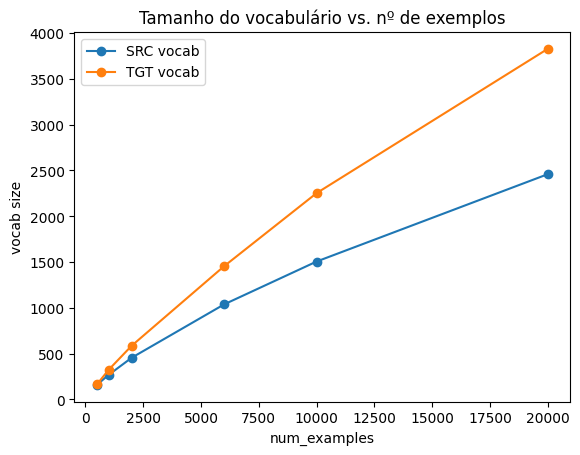

In [11]:
plt.figure()
plt.plot(df_vocab["num_examples"], df_vocab["vocab_src"], marker="o", label="SRC vocab")
plt.plot(df_vocab["num_examples"], df_vocab["vocab_tgt"], marker="o", label="TGT vocab")
plt.xlabel("num_examples")
plt.ylabel("vocab size")
plt.title("Tamanho do vocabulário vs. nº de exemplos")
plt.legend()
plt.show()
